<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda

('1.1.0', False)

# MNIST

## Torch

In [0]:
import torch

num_workers = 0  # number of subprocesses to use for data loading
batch_size = 64  # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation
imgsize = 28
epochs = 50
patience = 2  #early stopping

### Load Data

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

# build train/val indices
numtrain = len(train_data)
indices = list(range(numtrain))
np.random.shuffle(indices)
split = int(valid_size * numtrain)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

print(numtrain)

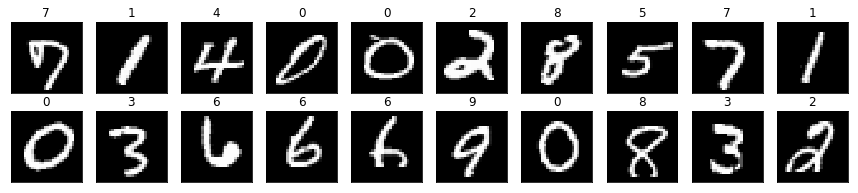

In [5]:
#visualize
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### Model

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        filters = 32               # number of convolutional filters to use
        pool_size = (2,2)          # size of pooling area for max pooling
        kernel_size = 3            # convolution kernel size
        self.conv1 = nn.Conv2d(1, filters, kernel_size, padding=1)       #in 1*imgsize*imgsize, out filters*imgsize*imgsize
        self.conv2 = nn.Conv2d(filters, filters, kernel_size, padding=1) #in filters*imgsize*imgsize, out filters*imgsize*imgsize
        self.pool = nn.MaxPool2d(*pool_size)                             #in filters*imgsize*imgsize, out filters*imgsize*imgsize/4
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(filters * imgsize*imgsize//4, 128)  #sees filters*imgsize*imgsize/4
        self.fc2 = nn.Linear(128, 10)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        filters = 32
        x = x.view(-1, filters * imgsize*imgsize//4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

criterion = nn.CrossEntropyLoss()  # Linear output with CrossEntropyLoss
optimizer = torch.optim.Adadelta(model.parameters())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout2): Dropout(p=0.5)
)


In [23]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


### Train

In [24]:
valid_loss_min = np.Inf            # best loss so far
epochs_without_improvement = 0
import tempfile                    # tempfile for saving model
_,weightsfile=tempfile.mkstemp()

if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = valid_loss = 0.
    
    # train
    model.train()
    for data, target in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.sampler)
        
    # validation
    model.eval() 
    for data, target in valid_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)        
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'Epoch {epoch+1}: \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), weightsfile)
        valid_loss_min = valid_loss
    else:
        epochs_without_improvement+=1
    if epochs_without_improvement>patience:
        break
        
model.load_state_dict(torch.load(weightsfile))

Epoch 1: 	Training Loss: 0.263325 	Validation Loss: 0.069751
Epoch 2: 	Training Loss: 0.086810 	Validation Loss: 0.053018
Epoch 3: 	Training Loss: 0.065068 	Validation Loss: 0.045796
Epoch 4: 	Training Loss: 0.054583 	Validation Loss: 0.044609
Epoch 5: 	Training Loss: 0.046198 	Validation Loss: 0.041176
Epoch 6: 	Training Loss: 0.040052 	Validation Loss: 0.049903
Epoch 7: 	Training Loss: 0.035796 	Validation Loss: 0.045282
Epoch 8: 	Training Loss: 0.033177 	Validation Loss: 0.045073


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Evaluate

In [27]:
test_loss = 0.0
class_correct = list(0. for i in range(10))  # number of correctly labeled data in each class
class_total = list(0. for i in range(10))    # number of data in each class

model.cpu()
model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    prob, pred = torch.max(output, 1)  # along the 2nd axis
    correct = pred.eq(target)
    
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'Test Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})')

Test Loss: 0.038658
Test Accuracy of 0: 99.18% (972/980)
Test Accuracy of 1: 99.38% (1128/1135)
Test Accuracy of 2: 99.52% (1027/1032)
Test Accuracy of 3: 99.50% (1005/1010)
Test Accuracy of 4: 99.19% (974/982)
Test Accuracy of 5: 98.99% (883/892)
Test Accuracy of 6: 98.54% (944/958)
Test Accuracy of 7: 98.35% (1011/1028)
Test Accuracy of 8: 98.46% (959/974)
Test Accuracy of 9: 96.83% (977/1009)
Test Accuracy (Overall): 98.80% (9880/10000)


## Keras

https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [0]:
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, optimizers
batch_size = 64
epochs = 50
imgsize = 28
filters = 32                 # number of convolutional filters to use
pool_size = (2, 2)              # size of pooling area for max pooling
kernel_size = (3, 3)            # convolution kernel size
patience = 2                 #early stopping

### Load data

In [30]:
(X_train, y_train), (X_test, y_test0) = datasets.mnist.load_data()
print(X_train.shape, y_train.shape)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.astype('float32')/255  # normalize data from 0 to 1
X_test  = X_test.astype('float32') /255

y_train = keras.utils.to_categorical(y_train, 10) # convert class vectors to binary class matrices
y_test = keras.utils.to_categorical(y_test0, 10)

print(X_train.shape, y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(60000, 784) (60000, 10)


In [0]:
# To conform to tensorflow's CNN
X_train = X_train.reshape(X_train.shape[0], imgsize, imgsize, 1)
X_test = X_test.reshape(X_test.shape[0], imgsize, imgsize, 1)
input_shape = (imgsize, imgsize, 1)

### Model

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(filters, kernel_size,   # no padding, input size is automatic
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.Conv2D(filters, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)        

In [35]:
print(X_train[0].shape)
print(model(X_train).shape)

(28, 28, 1)
(60000, 10)


### Train

In [0]:
from tensorflow import train
model.compile(loss='categorical_crossentropy',           # or keras.losses.categorical_crossentropy
              optimizer=train.AdadeltaOptimizer(),     # or keras.optimizers.Adadelta()
              metrics=['accuracy'])

import tempfile
_,weightsfile=tempfile.mkstemp()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
mc=ModelCheckpoint(weightsfile,monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,callbacks=[es,mc],
          validation_data=(X_test, y_test))
model.load_weights(weightsfile)

### Evaluate

In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_hat = model.predict_classes(X_test)
pd.crosstab(y_hat, y_test0)

Test loss: 0.026994537603552818
Test accuracy: 0.9913


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,977,0,2,0,0,2,4,0,2,2
1,0,1133,1,0,0,0,2,2,0,1
2,0,1,1021,2,0,0,0,6,2,0
3,0,1,0,1004,0,2,0,3,1,0
4,0,0,1,0,974,0,1,0,0,4
5,0,0,0,3,0,884,4,0,0,3
6,1,0,1,0,5,4,947,0,1,0
7,1,0,5,0,0,0,0,1013,1,2
8,1,0,1,1,0,0,0,1,966,3


# CIFAR-10

## Torch

In [84]:
import torch
import numpy as np
epochs = 50
batch_size = 20
valid_size = 0.2
imgsize = 32

### Load Data

In [85]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), # randomly flip and rotate
#     transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('~/.pytorch/CIFAR-10_data/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR-10_data/', train=False, download=True, transform=transform)

# train & val indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


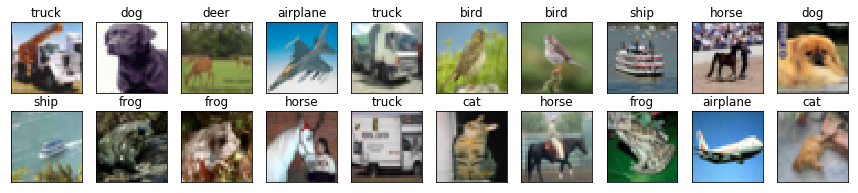

In [87]:
# just visualize
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]/2+.5,(1,2,0)))
    ax.set_title(classes[labels[idx]])

### Model

In [88]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  #in: 3*imgsize*imgsize; out: 16*imgsize*imgsize, then pool -> 16*imgsize*imgsize/4
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) #in: 16*imgsize*imgsize/4; out: 32*imgsize*imgsize/4, then pool -> 32*imgsize*imgsize/16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #in: 32*imgsize*imgsize/16; out: 64*imgsize*imgsize/16, then pool -> 64*imgsize*imgsize/64
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * imgsize*imgsize//64, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * imgsize*imgsize//64)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)
if cuda: model.cuda()
    
criterion = nn.CrossEntropyLoss()  # Linear output with CrossEntropyLoss
optimizer = torch.optim.Adadelta(model.parameters())

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [89]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([20, 3, 32, 32])
torch.Size([20, 10])


### Train

In [90]:
valid_loss_min = np.Inf            # best loss so far
epochs_without_improvement = 0
import tempfile                    # tempfile for saving model
_,weightsfile=tempfile.mkstemp()

if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = valid_loss = 0.
    
    # train
    model.train()
    for data, target in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.sampler)
        
    # validation
    model.eval() 
    for data, target in valid_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)        
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'Epoch {epoch+1}: \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), weightsfile)
        valid_loss_min = valid_loss
    else:
        epochs_without_improvement+=1
    if epochs_without_improvement>patience:
        break
        
model.load_state_dict(torch.load(weightsfile))

Epoch 1: 	Training Loss: 1.517106 	Validation Loss: 1.153209
Epoch 2: 	Training Loss: 1.162281 	Validation Loss: 1.105698
Epoch 3: 	Training Loss: 1.057955 	Validation Loss: 0.924957
Epoch 4: 	Training Loss: 1.012363 	Validation Loss: 0.937456
Epoch 5: 	Training Loss: 0.995850 	Validation Loss: 0.967144
Epoch 6: 	Training Loss: 0.989817 	Validation Loss: 0.988594


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Evaluate

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))  # number of correctly labeled data in each class
class_total = list(0. for i in range(10))    # number of data in each class

model.eval()
for data, target in test_loader:
    if cuda: data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    prob, pred = torch.max(output, 1)  # along the 2nd axis
    correct = pred.eq(target)
    
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'Test Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})')

In [ ]:
# just visualize
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if cuda:images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx]/2+.5,(1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Transfer DenseNet to cats/dogs

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%207%20-%20Loading%20Image%20Data%20(Solution).ipynb

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%208%20-%20Transfer%20Learning%20(Solution).ipynb

## Load data

In [0]:
import urllib.request,zipfile
import os,tempfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip','Cat_Dog_data.zip')
zipfile.ZipFile('Cat_Dog_data.zip').extractall()

Dataloader:

In [0]:
import torch
from torchvision import datasets, transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),     # add randomization for robustness
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],   #normalization parameters given by the model
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder('Cat_Dog_data/train', transform=train_transforms)
test_data = datasets.ImageFolder('Cat_Dog_data/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Example image/label:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


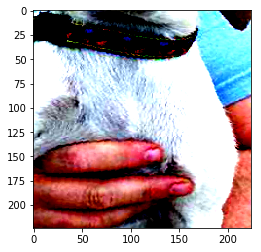

In [0]:
import matplotlib.pyplot as plt
images, labels = next(iter(trainloader))
image, label = images[0], labels[0]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
print(label)

## Load Model

In [0]:
from torch import nn
from torchvision import models

In [0]:
model = models.densenet121(pretrained=True)

for param in model.parameters():      # Freeze parameters of the feature detector
    param.requires_grad = False
    
print(f"old: {model.classifier}")     # seeing the input is 1024, we need to match it in our own classifier
from collections import OrderedDict   # create our own (binary) classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier
print(f"new: {model.classifier}")

old: Linear(in_features=1024, out_features=1000, bias=True)
new: Sequential(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)


In [0]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # only classifier's parameters

## Train

In [0]:
# estimate time on cpu/gpu:
import time
for device in ['cpu', 'cuda'][:torch.cuda.is_available()+1]:
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # only classifier's parameters
    model.to(device)
    
    (inputs, labels) = next(iter(trainloader))
    inputs, labels = inputs.to(device), labels.to(device)

    start = time.time()
    loss = criterion( model(inputs) , labels)
    loss.backward()
    optimizer.step()
        
    print(f"Device = {device}; First batch: {(time.time() - start):.3f} seconds")

Device = cpu; First batch: 3.553 seconds


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if it's available
model.to(device)

epochs = 1
print_every = 5

for epoch in range(epochs):
    running_loss = 0
    for i,(inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)    # train loss
                    
                    test_loss += batch_loss.item()           # test loss                   

                    ps = torch.exp(logps)                    # test accuracy
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. Step {i} "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            model.train()

# Transfer VGG16 to Flowers

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb

In [94]:
batch_size = 20
epochs = 2  # not early stopping

## Load data

In [93]:
import urllib.request,zipfile
import os,tempfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip','flower.zip')
zipfile.ZipFile('flower.zip').extractall()
print(os.getcwd())

/private/var/folders/r7/n9dny1wj46q8njz2gds66kqr0000gp/T


In [121]:
import torch
from torchvision import datasets, transforms
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder('flower_photos/train', transform=data_transforms)
test_data = datasets.ImageFolder('flower_photos/test', transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Num training images:  3130
Num test images:  540


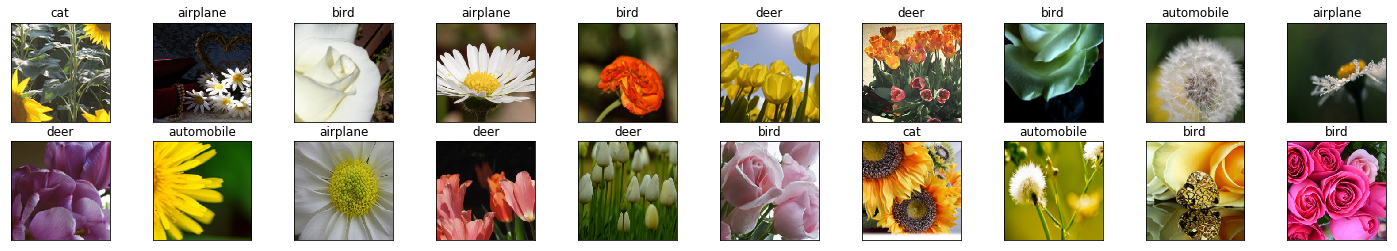

In [102]:
# visualize
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Load VGG19 Model

In [113]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():# Freeze the feature extractor
    param.requires_grad = False

In [120]:
print(vgg16.classifier)
print(vgg16.classifier[-1].in_features) # match this for custom classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
4096


In [123]:
import torch.nn as nn
vgg16.classifier[-1] = nn.Linear(4096, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01)

## Train

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    
    for i, (data, target) in enumerate(train_loader):
        if cuda: data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if i % 20 == 0:
            print(f'Epoch {epoch}, Batch {i} loss: {train_loss / 20:.16f}')
            train_loss = 0.0

## Evaluate

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()

for data, target in test_loader:    
    if cuda: data, target = data.cuda(), target.cuda()
        
    output = vgg16(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}')

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))